## Test two ways of computing $h^2$

### The variance should be conserved in a selected domain. The value for the selected domain should be the sum of the subdomains.

**SAH** (windowing & spectral) *vs* **JSL** (plane fit)

In [1]:
%matplotlib inline

import xrft
import math
import time
import scipy.io
import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from scipy import signal
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from IPython.display import display, Math

from gsw import f
from matplotlib.colors import LogNorm
from scipy.fftpack import fft2, fftn, fftshift

import warnings
warnings.filterwarnings('ignore')

In [2]:
def windowing(topog_sample, alpha=0.8, border=0.9):

    # shape parameter of the Tukey window (flat + cosine tapered region)
    # - raidus < alpha, factor = 1
    # - alpha < radius < alpha, factor decays from 1 to 0
    # - radius > border, factor = 0
    
    vari = np.var(topog_sample)

    ydim, xdim = topog_sample.dims
    nx = topog_sample[xdim].size
    ny = topog_sample[ydim].size

    # Create coordinate grid
    y = np.linspace(-1, 1, ny)
    x = np.linspace(-1, 1, nx)
    xv, yv = np.meshgrid(x, y)
    
    # Calculate radial distance from the center
    r = np.sqrt(xv**2 + yv**2)
    
    # Initialize the window with zeros
    window = np.zeros((ny, nx))
    
    # Apply Tukey window formula
    for j in range(ny):
        for i in range(nx):
            if r[j, i] <= alpha:
                window[j, i] = 1
            elif r[j, i] <= border:
                window[j, i] = 0.5*(1 + np.cos( np.pi * (r[j, i] - alpha ) / (border - alpha) ))
            else:
                window[j, i] = 0

    topog_filt = topog_sample * window
    varf = np.var(topog_filt)
    fac  = np.sqrt(vari/varf).values
    window *= fac
    topog_filt *= fac

    return topog_filt, window, fac

In [3]:
def fft_topog(topog,delta_lon,delta_lat,alpha=0.8,border=0.9,k_grid_units=True):

    ydim, xdim = topog.dims
    nx = topog[xdim].size
    ny = topog[ydim].size
    dx = np.mean(np.diff(topog[xdim]))*delta_lon*1e+3
    dy = np.mean(np.diff(topog[ydim]))*delta_lat*1e+3

    # demean
    topog -= topog.mean(skipna=True) 

    # windowing
    topog_filt, window, fac = windowing(topog,alpha=0.8,border=0.9)

    # FFT
    topog_fft = fft2(topog_filt.values)
    topog_spd = (topog_fft*topog_fft.conjugate()).real
    topog_spd[0,0] = np.nan          # nan at removed zero frequency
    topog_spd = fftshift(topog_spd)  # put zero wavenumber in array centre
    topog_spd *= dx*dy

    if (k_grid_units):
        # k in units cycles/dx:
        topog_spd = xr.DataArray(topog_spd, dims=['ky','kx'], 
                                 coords={'ky': np.linspace(-0.5, 0.5+(ny%2-1)/ny, num=ny), 
                                         'kx': np.linspace(-0.5, 0.5+(nx%2-1)/nx, num=nx)},
                                 attrs={'long_name': 'wavenumber spectrum in grid units'})
        topog_spd.kx.attrs['units'] = 'cycles/dx'
        topog_spd.ky.attrs['units'] = 'cycles/dy'
        topog_spd.kx.attrs['long_name'] = 'x wavenumber'
        topog_spd.ky.attrs['long_name'] = 'y wavenumber'

        # No rescaling

    else:
        # k in units cycles/(units of dx)
        topog_spd = xr.DataArray(topog_spd, dims=['ky','kx'], 
                                 coords={'ky': np.linspace(-0.5, 0.5+(ny%2-1)/ny, num=ny)*(2*np.pi/dy),
                                         'kx': np.linspace(-0.5, 0.5+(nx%2-1)/nx, num=nx)*(2*np.pi/dx)},
                                 attrs={'long_name': 'wavenumber spectrum in grid units'})
        topog_spd.kx.attrs['units'] = 'radians/meters'
        topog_spd.ky.attrs['units'] = 'radians/meters'
        topog_spd.kx.attrs['long_name'] = 'x wavenumber'
        topog_spd.ky.attrs['long_name'] = 'y wavenumber'

        # Rescale to satisfy Parseval's theorem:
        topog_spd /= 4*np.pi**2./dx/dy

    return topog_spd, topog_filt, dx, dy, window, fac

In [4]:
def get_delta(lat):

    # compute the distance in km at this lon and lat
    delta_lon = 2 * np.pi * (6371 * np.cos(lat*np.pi/180)) / 360
    delta_lat = 1 * np.pi * 6371 / 180
    
    return delta_lon, delta_lat

In [5]:
def compute_h_rms(A,topog_spd_2d):

    const = 1 / (4 * A * np.pi**2)
    kx_2D, ky_2D = np.meshgrid(topog_spd_2d.kx,topog_spd_2d.ky,indexing='xy')
    dkx, dky = np.max(np.diff(topog_spd_2d.kx)), np.max(np.diff(topog_spd_2d.ky))
    int_kl = topog_spd_2d * dkx * dky
    h_rms = np.sqrt(const * np.nansum(int_kl[:]))
    
    K_2D = np.sqrt(kx_2D**2 + ky_2D**2)
    int_kh2 = K_2D * topog_spd_2d * dkx * dky
    kh2 = const * np.nansum(int_kh2[:])

    return h_rms, kh2

In [6]:
def my_floor(a, precision=2):
    return np.round(a - 0.5 * 10**(-precision), precision)

In [7]:
# select a domain, 10 deg by 10 deg
topog = xr.open_dataset('/g/data/nm03/lxy581/synbath/SYNBATH.nc')
topog_sample = topog.z[240*135:240*145,240*145:240*155]

ydim, xdim = topog_sample.dims
nx = topog_sample[xdim].size
ny = topog_sample[ydim].size

lon = topog_sample.lon
lat = topog_sample.lat

yind = 240*140-1
xind = 240*150-1
print('Location for the centre point: \nLon: %.1f W;' % np.abs(topog.lon[xind].values),'\nLat: %.1f N.' % topog.lat[yind].values)

Location for the centre point: 
Lon: 30.0 W; 
Lat: 50.0 N.


### Spectral analysis (including demean and windowing)

In [8]:
delta_lon, delta_lat = get_delta(50)
A_loc = 10 * delta_lon * 1e+3 * 10 * delta_lat * 1e+3

In [9]:
topog_spd_2d, topog_filt, dx, dy, window, fac = fft_topog(topog_sample,delta_lon,delta_lat,alpha=0.8,border=0.9,k_grid_units=False)

#### Tried to see if the area matters (area-weighted-?)
The **window** array is the scaling factor, from constant **fac(>1)** to 1 to 0.

In [10]:
A_loc_win = np.full((ny,nx),np.nan)
for j in range(ny):
    delta_lon_tmp, delta_lat_tmp = get_delta(topog_sample.lat[j])
    A_loc_win[j,:] = delta_lon_tmp *1e+3 /240 * delta_lat_tmp *1e+3 /240

print('Latitude-dependent area sum: %3.2e' % np.nansum(A_loc_win))
print('Area sum computed using 50N: %3.2e' % A_loc)

A_fac = np.full((ny,nx),np.nan)
A_fac[window>0] = 1
A_fac[window==0] = 0
A_loc_win *= A_fac
print('Latitude-dependent area sum, weighted by the window: %3.2e' % np.nansum(A_loc_win))

Latitude-dependent area sum: 7.94e+11
Area sum computed using 50N: 7.95e+11
Latitude-dependent area sum, weighted by the window: 5.05e+11


### Filter the topography and keep in only in the center of the domain (flat edges)

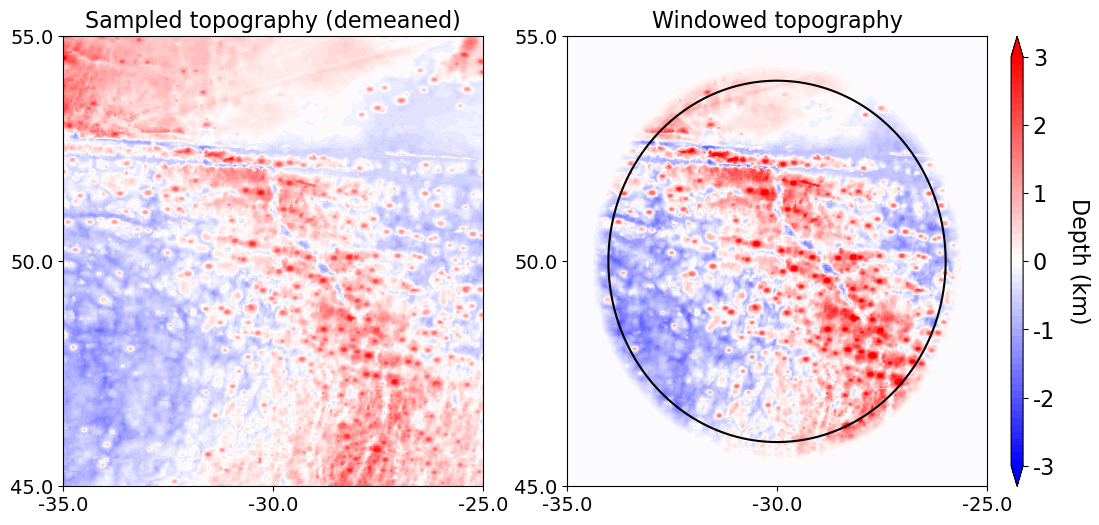

In [11]:
varlist = ['topog_sample','topog_filt']
title   = ['Sampled topography (demeaned)', 'Windowed topography']
levels  = np.arange(-3000,3000+100,100)

fig = plt.figure(figsize=(12, 6))
axs = []

gridsubs = gridspec.GridSpec(1,2)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

for I, (ax, var) in enumerate(zip(axs, varlist)):

    p = ax.contourf(globals()[var], levels=levels, cmap='bwr', vmin=-3000, vmax=3000, extend="both") 

    if I==0:
        ax.set_position([0.1,0.1,0.35,0.75])
        
    if I==1:
        ax.contour(window, levels=np.array([my_floor(fac)]), colors='k')
        ax.set_position([0.52,0.1,0.35,0.75])

    ax.set_title(title[I],fontsize=16)
    ax.set_xticks(np.arange(0,240*10+240*5,240*5))
    ax.set_yticks(np.arange(0,240*10+240*5,240*5))
    xlabels = np.array([np.round(topog.lon[240*145].values), 
                        np.round(topog.lon[240*150].values), 
                        np.round(topog.lon[240*155].values)])
    ylabels = np.array([np.round(topog.lat[240*135].values), 
                        np.round(topog.lat[240*140].values), 
                        np.round(topog.lat[240*145].values)])
    # ax.set_xticklabels(['35$^{\circ}$W','30$^{\circ}$W','25$^{\circ}$W'],fontsize=14)
    # ax.set_yticklabels(['45$^{\circ}$N','50$^{\circ}$N','55$^{\circ}$N'],fontsize=14)
    ax.set_xticklabels(xlabels,fontsize=14)
    ax.set_yticklabels(ylabels,fontsize=14)
    tick_locs = np.arange(-3000,3000+1000,1000)
    tick_labels = np.array(['-3','-2','-1','0','1','2','3'])
    
    if I==1:    
        ax_cb = plt.axes([0.89, 0.1, 0.01, 0.75])  
        cb = plt.colorbar(p, cax=ax_cb, orientation='vertical', extend='both')
        cb.ax.set_ylabel('Depth (km)',fontsize=16,rotation=270,labelpad=25);
        cb.ax.tick_params(labelsize=16)
        cb.locator   = matplotlib.ticker.FixedLocator(tick_locs)
        cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)

### Test if the window conserves the variance

In [12]:
topog_variance = np.var(topog_sample)
topog_filt_variance = np.var(topog_filt)
print('Variance for topography: %3.2e'%topog_variance.values)
print('Area-integrated variance before windowing: %3.2e'%(topog_variance.values * A_loc))
print('Area-integrated variance after windowing:  %3.2e'%(topog_filt_variance.values * A_loc))

Variance for topography: 3.56e+05
Area-integrated variance before windowing: 2.83e+17
Area-integrated variance after windowing:  2.83e+17


In [13]:
print(np.nanmean(topog_sample))
print(np.nanmean(topog_filt))

0.002649075
-19.136795657234128


### Check Parseval's theorem

In [14]:
dkx, dky = np.max(np.diff(topog_spd_2d.kx)), np.max(np.diff(topog_spd_2d.ky))
fft2dsum = topog_spd_2d.sum().sum()*dkx*dky
print('2D spectrum variance sum (k-space) = %5.4e' % fft2dsum)
var_int_x = np.nansum(topog_filt **2 * dy * dx)
print('2D spectrum variance sum (x-space) = %5.4e' % var_int_x)

2D spectrum variance sum (k-space) = 2.8333e+17
2D spectrum variance sum (x-space) = 2.8362e+17


### Compute $h^2$ for the entire domain

In [15]:
h_rms, kh2 = compute_h_rms(A_loc,topog_spd_2d)
var_int_k = h_rms**2 * 4 * A_loc * np.pi**2
print('rms height = %.2f m' % h_rms)
print('variance inferred from hrms = %5.4e' % var_int_k)
print('k h^2 = %3.2e' % kh2)

rms height = 95.03 m
variance inferred from hrms = 2.8333e+17
k h^2 = 9.40e-01


### Increase the size of the windowed topography (fill with zeros)

In [16]:
ny, nx = topog_sample.shape
topog_filt_expanded = np.zeros((int(2*ny),int(2*nx)))
topog_filt_expanded[int(ny/2):int(3*ny/2), int(nx/2):int(3*nx/2)] = topog_filt

lon_expanded = np.zeros((int(2*nx)))
lat_expanded = np.zeros((int(2*ny)))

lon_expanded[int(nx/2):int(3*nx/2)] = topog_sample.lon
lat_expanded[int(ny/2):int(3*ny/2)] = topog_sample.lat

lon_expanded[0:int(nx/2)]  = topog.lon[240*145-int(nx/2):240*145] 
lon_expanded[int(3*nx/2):] = topog.lon[240*155:240*155+int(nx/2)] 

lat_expanded[0:int(ny/2)]  = topog.lat[240*135-int(ny/2):240*135] 
lat_expanded[int(3*ny/2):] = topog.lat[240*145:240*145+int(ny/2)] 

topog_filt_exp = xr.DataArray(topog_filt_expanded, dims=['lat','lon'], 
                              coords={'lat': lat_expanded, 
                                      'lon': lon_expanded})

In [17]:
A_loc_exp = 20 * delta_lon * 1e+3 * 20 * delta_lat * 1e+3
topog_exp_variance = np.var(topog_filt_exp) 
print('Area-integrated variance for the expanded topography: %3.2e'%(topog_exp_variance * A_loc_exp))

Area-integrated variance for the expanded topography: 2.84e+17


In [18]:
print('Check nanmean for filtered topography: %3.2e'%np.nanmean(topog_filt))
print('Check nanmean for expanded topography: %3.2e\n'%np.nanmean(topog_filt_exp))

topog_filt_variance = np.var(topog_filt) 
topog_exp_variance = np.var(topog_filt_exp) 

print('Area-integrated variance for the expanded topography: %3.2e'%(topog_exp_variance * A_loc_exp))
print('Area-integrated variance for the filtered topography: %3.2e'%(topog_filt_variance.values * A_loc))

Check nanmean for filtered topography: -1.91e+01
Check nanmean for expanded topography: -4.78e+00

Area-integrated variance for the expanded topography: 2.84e+17
Area-integrated variance for the filtered topography: 2.83e+17


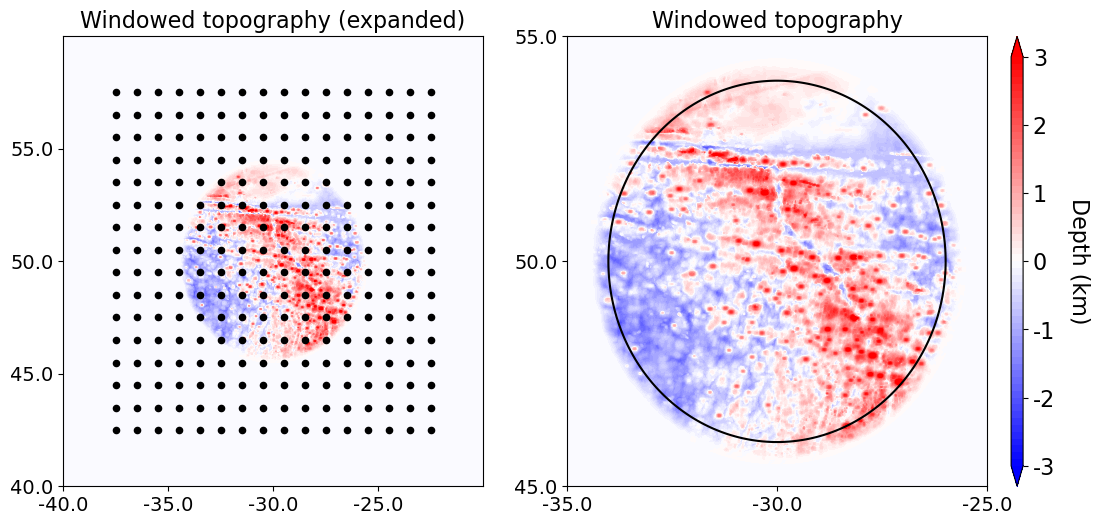

In [23]:
varlist = ['topog_filt_exp','topog_filt']
title   = ['Windowed topography (expanded)', 'Windowed topography']
levels  = np.arange(-3000,3000+100,100)

fig = plt.figure(figsize=(12, 6))
axs = []

gridsubs = gridspec.GridSpec(1,2)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

for I, (ax, var) in enumerate(zip(axs, varlist)):

    p = ax.contourf(globals()[var], x='lon', y='lat', levels=levels, cmap='bwr', vmin=-3000, vmax=3000, extend="both") 
    ax.set_title(title[I],fontsize=16)
    
    if I==0:
        ax.set_xticks(np.array([0,nx/2,nx/2+240*5,nx/2+240*10,nx/2+240*15]))
        ax.set_yticks(np.array([0,ny/2,ny/2+240*5,ny/2+240*10,ny/2+240*15]))
        xlabels = np.array([np.round(topog.lon[240*145-int(nx/2)].values,1),
                            np.round(topog.lon[240*145].values), 
                            np.round(topog.lon[240*150].values), 
                            np.round(topog.lon[240*155].values),
                            np.round(topog.lon[240*155+int(nx/2)].values,1)])
        ylabels = np.array([np.round(topog.lat[240*135-int(ny/2)].values,1),
                            np.round(topog.lat[240*135].values), 
                            np.round(topog.lat[240*140].values), 
                            np.round(topog.lat[240*145].values),
                            np.round(topog.lat[240*145+int(ny/2)].values,1)])
        ax.set_xticklabels(xlabels,fontsize=14)
        ax.set_yticklabels(ylabels,fontsize=14)
        ax.set_position([0.1,0.1,0.35,0.75])

        ny, nx = topog_sample.shape
        inv_res = 10 
        tilenum = int(inv_res+1)+5
        for j in np.arange(0,tilenum):
            for i in np.arange(0,tilenum):
                lon_center = np.array([int(i*nx/inv_res+0.25*nx)])
                lat_center = np.array([int(j*ny/inv_res+0.25*ny)])
                ax.scatter(lon_center, lat_center, s=20, color='k', marker='o')
    
    if I==1:
        ax.contour(window, levels=np.array([my_floor(fac)]), colors='k')
        ax.set_xticks(np.arange(0,240*10+240*5,240*5))
        ax.set_yticks(np.arange(0,240*10+240*5,240*5))
        xlabels = np.array([np.round(topog.lon[240*145].values), 
                           np.round(topog.lon[240*150].values), 
                           np.round(topog.lon[240*155].values)])
        ylabels = np.array([np.round(topog.lat[240*135].values), 
                           np.round(topog.lat[240*140].values), 
                           np.round(topog.lat[240*145].values)])
        ax.set_xticklabels(xlabels,fontsize=14)
        ax.set_yticklabels(ylabels,fontsize=14)
        ax.set_position([0.52,0.1,0.35,0.75])

        ax_cb = plt.axes([0.89, 0.1, 0.01, 0.75])  
        cb = plt.colorbar(p, cax=ax_cb, orientation='vertical', extend='both')
        cb.ax.set_ylabel('Depth (km)',fontsize=16,rotation=270,labelpad=25);
        cb.ax.tick_params(labelsize=16)
        tick_locs = np.arange(-3000,3000+1000,1000)
        tick_labels = np.array(['-3','-2','-1','0','1','2','3'])
        cb.locator   = matplotlib.ticker.FixedLocator(tick_locs)
        cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)

### Compute $h^2$ and $k\cdot h^2$ for small domains

#### Locate the lower left points for all tiles

For some reason, **topog_filt_exp** is updated every time in the loop, so I made a copy of it and used the copy.

In [24]:
ny, nx = topog_sample.shape
print('nx, ny = ', nx, ny)

A_tile = 5 * delta_lon * 1e+3 * 5 * delta_lat * 1e+3
total_var = 0

inv_res = 10 
tilenum = int(inv_res+1)+5
print('inv_res, tilenum = ', inv_res, tilenum)
print('number of tiles  = ', tilenum*tilenum)

tvar = np.full((tilenum,tilenum), np.nan)
hrms = np.full((tilenum,tilenum), np.nan)
tkh2 = np.full((tilenum,tilenum), np.nan)

for j in np.arange(0,tilenum):
    print('j = %d'%j)
    for i in np.arange(0,tilenum):

        topog_filt_exp_cp = topog_filt_exp.copy()
        topog_tile = topog_filt_exp_cp[int(j*ny/inv_res):int(ny/2+j*ny/inv_res),int(i*nx/inv_res):int(nx/2+i*nx/inv_res)]
        lon_center = lon_expanded[int(i*nx/inv_res+nx/4)]
        lat_center = lat_expanded[int(j*ny/inv_res+ny/4)]
        tvar[j,i] = np.var(topog_tile).values
        total_var = total_var + tvar[j,i]

        # topog_exp_variance = np.var(topog_filt_exp) 
        # print('Area-integrated variance for the expanded topography: %3.2e'%(topog_exp_variance * A_loc_exp))

        # spectral analysis for each tile
        tile_spec, tile_filt, tile_dx, tile_dy, tile_win, tile_fac = fft_topog(topog_tile,delta_lon,delta_lat,alpha=0.8,border=0.9,k_grid_units=False)
        
        # print('Variance before windowing: %3.2e '%np.var(topog_tile).values)
        # print('Variance  after windowing: %3.2e '%np.var(tile_filt).values)
        
        hrms[j,i], tkh2[j,i] = compute_h_rms(A_tile, tile_spec)

        # print('Checking Parsevals theorem: ')
        # dkx, dky = np.max(np.diff(tile_spec.kx)), np.max(np.diff(tile_spec.ky))
        # fft2dsum = tile_spec.sum().sum()*dkx*dky
        # print('2D sum (k-space) = %3.2e' % fft2dsum)
        # var_int_x = np.nansum(topog_tile **2 * dy * dx)
        # print('2D sum (x-space) = %3.2e \n' % var_int_x)

print('Confirmed that \nnp.var(tile_filt).values*A_tile = hrms[j,i]**2 * 4 * A_tile * np.pi**2!')

ave_var = total_var / (tilenum*tilenum)    

print('Ave of variance: %3.2e'% (ave_var*A_tile))
print('Ave of kh$^2$:   %3.2e'% np.nanmean(tkh2))

nx, ny =  2400 2400
inv_res, tilenum =  10 16
number of tiles  =  256
j = 0
j = 1
j = 2
j = 3
j = 4
j = 5
j = 6
j = 7
j = 8
j = 9
j = 10
j = 11
j = 12
j = 13
j = 14
j = 15
Confirmed that 
np.var(tile_filt).values*A_tile = hrms[j,i]**2 * 4 * A_tile * np.pi**2!
Ave of variance: 2.52e+16
Ave of kh$^2$:   4.03e-01


In [26]:
print(topog_filt_exp.shape)
topog_exp_variance = np.var(topog_filt_exp) 
print('Area-integrated variance for the expanded topography: %3.2e'%(topog_exp_variance * A_loc_exp))

(4800, 4800)
Area-integrated variance for the expanded topography: 2.84e+17


In [51]:
print('Ave of variance (estimated using hrms): %3.2e' % np.nanmean(hrms**2 * 4 * A_tile * np.pi**2))
print('Ave of hrms: %.2f' % np.nanmean(hrms))

Ave of variance (estimated using hrms): 2.52e+16
Ave of hrms: 38.61


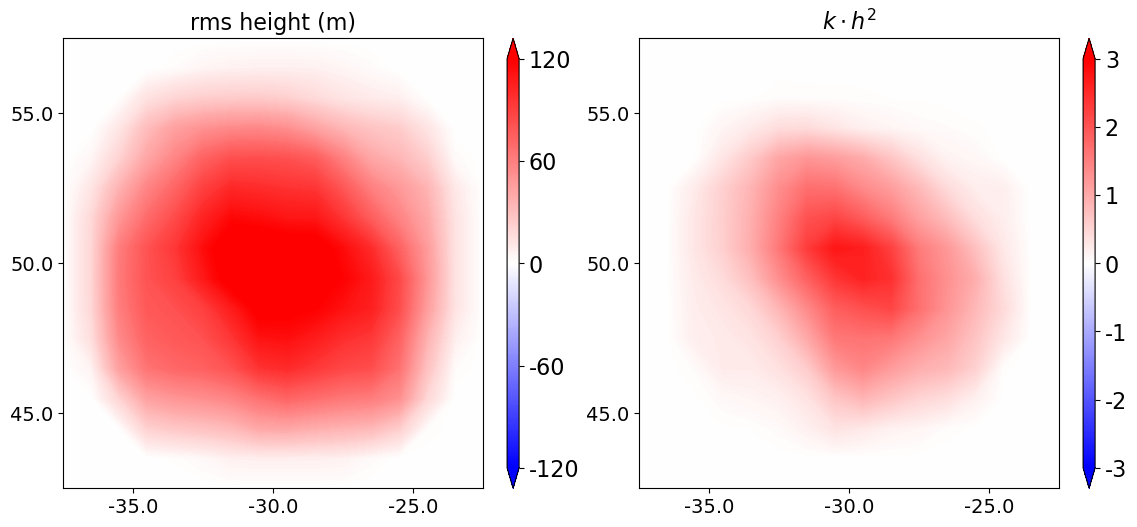

In [34]:
varlist = ['hrms','tkh2']
title   = ['rms height (m)', r'$k \cdot h^2$']
hlevels = np.arange(-120,120+1,1)
khlevel = np.arange(-3,3+0.01,0.01)

lon_center = np.full((tilenum),np.nan)
lat_center = np.full((tilenum),np.nan)

for j in np.arange(0,tilenum):
    lat_center[j] = lat_expanded[int(j*ny/inv_res+ny/4)]
for i in np.arange(0,tilenum):
    lon_center[i] = lon_expanded[int(i*nx/inv_res+nx/4)]

fig = plt.figure(figsize=(12, 6))
axs = []

gridsubs = gridspec.GridSpec(1,2)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

for I, (ax, var) in enumerate(zip(axs, varlist)):

    ax.set_title(title[I],fontsize=16)
    
    if I==0:
        p = ax.contourf(lon_center,lat_center,globals()[var], levels=hlevels, cmap='bwr', vmin=-120, vmax=120, extend="both") 
        ax.set_position([0.1,0.1,0.35,0.75])

        ax_cb = plt.axes([0.47, 0.1, 0.01, 0.75])  
        cb = plt.colorbar(p, cax=ax_cb, orientation='vertical', extend='both')
        cb.ax.tick_params(labelsize=16)
        tick_locs = np.arange(-120,120+60,60)
        tick_labels = np.array(['-120','-60','0','60','120'])
        cb.locator   = matplotlib.ticker.FixedLocator(tick_locs)
        cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
        
    if I==1:
        p = ax.contourf(lon_center,lat_center,globals()[var], levels=khlevel, cmap='bwr', vmin=-3, vmax=3, extend="both") 
        ax.set_position([0.58,0.1,0.35,0.75])

        ax_cb = plt.axes([0.95, 0.1, 0.01, 0.75])  
        cb = plt.colorbar(p, cax=ax_cb, orientation='vertical', extend='both')
        cb.ax.set_ylabel('',fontsize=16,rotation=270,labelpad=25);
        cb.ax.tick_params(labelsize=16)
        tick_locs = np.arange(-3,3+1,1)
        tick_labels = np.array(['-3','-2','-1','0','1','2','3'])
        cb.locator   = matplotlib.ticker.FixedLocator(tick_locs)
        cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)

    ax.set_xticks(np.arange(-35,-25+5,5))
    ax.set_yticks(np.arange( 45, 55+5,5))
    xlabels = np.array([np.round(topog.lon[240*145].values), 
                       np.round(topog.lon[240*150].values), 
                       np.round(topog.lon[240*155].values)])
    ylabels = np.array([np.round(topog.lat[240*135].values), 
                       np.round(topog.lat[240*140].values), 
                       np.round(topog.lat[240*145].values)])
    ax.set_xticklabels(xlabels,fontsize=14)
    ax.set_yticklabels(ylabels,fontsize=14)

In [35]:
topog_exp_variance = np.var(topog_filt_exp) 
print('Area-integrated variance for the expanded topography: %3.2e'%(topog_exp_variance * A_loc_exp))

Area-integrated variance for the expanded topography: 2.84e+17


### Update $h^2$ for the entire domain

Only include **scales smaller than the tile size** (i.e., **wavenumbers larger than that corresponding to the tile size**)!

In [45]:
topog_windowed_variance = np.var(topog_filt)
topog_expanded_variance = np.var(topog_filt_exp)

A_loc     = 10 * delta_lon * 1e+3 * 10 * delta_lat * 1e+3
A_loc_exp = 20 * delta_lon * 1e+3 * 20 * delta_lat * 1e+3

print('Area-integrated variance for the windowed topography: %3.2e'%(topog_windowed_variance.values * A_loc))
print('Area-integrated variance for the expanded topography: %3.2e'%(topog_expanded_variance.values * A_loc_exp))

Area-integrated variance for the windowed topography: 2.83e+17
Area-integrated variance for the expanded topography: 2.84e+17


The function **compute_h_rms_kmin** returns rms height and kh2 for scales smaller than the max scale inferred from kx_min and ky_min.

In [46]:
def compute_h_rms_kmin(A,topog_spd_2d,kx_min,ky_min):

    const = 1 / (4 * A * np.pi**2)
    
    K_2D_min = np.sqrt(kx_min**2 + ky_min**2)
    kx_2D, ky_2D = np.meshgrid(topog_spd_2d.kx,topog_spd_2d.ky,indexing='xy')
    dkx, dky = np.max(np.diff(topog_spd_2d.kx)), np.max(np.diff(topog_spd_2d.ky))

    L_2D_max = 2 * np.pi / K_2D_min
    scale = 2 * np.pi / np.sqrt(kx_2D**2 + ky_2D**2)
    
    topog_spd_2d_masked = topog_spd_2d.where(scale < L_2D_max)

    int_kl = topog_spd_2d_masked * dkx * dky
    h_rms = np.sqrt(const * np.nansum(int_kl[:]))

    K_2D = np.sqrt(kx_2D**2 + ky_2D**2)
    int_kh2 = K_2D * topog_spd_2d_masked * dkx * dky
    kh2 = const * np.nansum(int_kh2[:])

    return h_rms, kh2

#### Compute rms height and kh2 for scales smaller than the max scale in the sub-domain for the **windowed** topography.

In [49]:
topog_spd_2d, topog_filt_fil, dx, dy, window, fac = fft_topog(topog_filt,delta_lon,delta_lat,alpha=0.8,border=0.9,k_grid_units=False)
A_loc = 10 * delta_lon * 1e+3 * 10 * delta_lat * 1e+3

kymin_tile = np.nanmin(np.diff(tile_spec.ky))
kxmin_tile = np.nanmin(np.diff(tile_spec.kx))

print('Windowed topography: \n')
print('All scales:')

h_rms, kh2 = compute_h_rms(A_loc,topog_spd_2d)
var_int_k = h_rms**2 * 4 * A_loc * np.pi**2
print('variance: %3.2e'% (np.var(topog_filt).values*A_loc))
print('rms height = %.2f m' % h_rms)
print('h_rms^2 * 4 * A * np.pi**2 = %3.2e' % var_int_k)
print('k h$^2$: % 3.2e\n'%kh2)

print('Scales smaller than max in the sub-domain:')
h_rms_kmin, kh2_kmin = compute_h_rms_kmin(A_loc,topog_spd_2d,kxmin_tile,kymin_tile)
var_int_k_kmin = h_rms_kmin**2 * 4 * A_loc * np.pi**2
print('variance: %3.2e'% (np.var(topog_filt_fil).values*A_loc))
print('rms height = %.2f m' % h_rms_kmin)
print('h_rms^2 * 4 * A * np.pi**2 = %3.2e' % var_int_k_kmin)
print('k h$^2$: % 3.2e'%kh2_kmin)

Windowed topography: 

All scales:
variance: 2.83e+17
rms height = 95.03 m
h_rms^2 * 4 * A * np.pi**2 = 2.83e+17
k h$^2$:  9.51e-01

Scales smaller than max in the sub-domain:
variance: 2.83e+17
rms height = 71.20 m
h_rms^2 * 4 * A * np.pi**2 = 1.59e+17
k h$^2$:  9.06e-01


#### Compute rms height and kh2 for scales smaller than the max scale in the sub-domain for the **expanded** topography.

In [50]:
topog_spd_exp, topog_filt_exp_filt, dx, dy, window, fac = fft_topog(topog_filt_exp,delta_lon,delta_lat,alpha=0.8,border=0.9,k_grid_units=False)

print('Expanded topography: \n')
print('All scales:')
h_rms, kh2 = compute_h_rms(A_loc_exp,topog_spd_exp)
var_int_k = h_rms**2 * 4 * A_loc_exp * np.pi**2
print('variance: %3.2e'% (np.var(topog_filt_exp).values*A_loc_exp))
print('rms height = %.2f m' % h_rms)
print('h_rms^2 * 4 * A * np.pi**2 = %3.2e' % var_int_k)
print('k h$^2$: % 3.2e\n'%kh2)

print('Scales smaller than max in the sub-domain:')
h_rms_kmin, kh2_kmin = compute_h_rms_kmin(A_loc_exp,topog_spd_exp,kxmin_tile,kymin_tile)
var_int_k_kmin = h_rms_kmin**2 * 4 * A_loc_exp * np.pi**2
print('variance: %3.2e'% (np.var(topog_filt_exp_filt).values*A_loc_exp))
print('rms height = %.2f m' % h_rms_kmin)
print('h_rms^2 * 4 * A * np.pi**2 = %3.2e' % var_int_k_kmin)
print('k h$^2$: % 3.2e'%kh2_kmin)

Expanded topography: 

All scales:
variance: 2.84e+17
rms height = 47.53 m
h_rms^2 * 4 * A * np.pi**2 = 2.84e+17
k h$^2$:  2.35e-01

Scales smaller than max in the sub-domain:
variance: 2.84e+17
rms height = 35.05 m
h_rms^2 * 4 * A * np.pi**2 = 1.54e+17
k h$^2$:  2.23e-01
